In [1]:
# Импортируем необходимые модули
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [2]:
# Считываем данные из файла в DataFrame
data = pd.read_csv('bank-additional-full.csv', sep = ';', engine = 'python')
data_const=data
type(data)

pandas.core.frame.DataFrame

In [3]:
categorical_columns = [c for c in data.columns if data[c].dtype.name == 'object']
numerical_columns   = [c for c in data.columns if data[c].dtype.name != 'object']
print(categorical_columns)
print(numerical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [4]:
data = data.fillna(data.median(axis = 0), axis = 0)
# Для категориальных данных присутствует значение 'unknown' 
# Произведем замену'unknown' = nan
data = data.replace('unknown', np.nan)
# Заполняем категориальные признаки медианным значением (для тех, где < 41188)
data['job'] = data['job'].fillna('admin.')
col = ('marital', 'education', 'default', 'housing', 'loan')
data_describe = data.describe(include = [object])
for c in categorical_columns:
    data[c] = data[c].fillna(data_describe[c]['top'])
    


In [5]:
# Для категориальных признаков требуется провести процедуру векторизации, где наличие признака представляется в виде вектора
# с 1 в соответствующей этому признаку позиции
binary_columns    = [c for c in categorical_columns if data_describe[c]['unique'] == 2]
nonbinary_columns = [c for c in categorical_columns if data_describe[c]['unique'] > 2]
print(binary_columns, nonbinary_columns)

# Все категориальные значения (с двумя ответами) заменяем на бинарные
for b_coll in binary_columns[0:len(binary_columns)-1]:
    u_data = data[b_coll].unique()
    data.at[data[b_coll] == u_data[0], b_coll] = 0
    data.at[data[b_coll] == u_data[1], b_coll] = 1
    
data_nonbinary = pd.get_dummies(data[nonbinary_columns])


data_numerical = data[numerical_columns]
data_numerical.describe()

data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data_numerical.head()



['default', 'housing', 'loan', 'contact', 'y'] ['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']


,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,1.533016,0.010471,-0.565915,0.195412,-0.34949,0.648084,0.722714,0.886436,0.712451,0.331676
1,1.628973,-0.421495,-0.565915,0.195412,-0.34949,0.648084,0.722714,0.886436,0.712451,0.331676
2,-0.290182,-0.124518,-0.565915,0.195412,-0.34949,0.648084,0.722714,0.886436,0.712451,0.331676
3,-0.002309,-0.413782,-0.565915,0.195412,-0.34949,0.648084,0.722714,0.886436,0.712451,0.331676
4,1.533016,0.187886,-0.565915,0.195412,-0.34949,0.648084,0.722714,0.886436,0.712451,0.331676


In [6]:
# Все полученные матрицы собираем в одну 
data = pd.concat((data_numerical, data_nonbinary, data[binary_columns]), axis = 1)
print(data.shape)



(41188, 54)


In [8]:
# Class count 0-no, 1-yes
count_class_0, count_class_1 = data['y'].value_counts()

# Divide by class
df_class_0 = data[data['y'] == 'no']
df_class_1 = data[data['y'] == 'yes']

df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_test_over = pd.concat([df_class_0, df_class_1_over], axis=0)


In [9]:
# data.drop
# X = df_test_under.drop(('y'), axis = 1)
# y = df_test_under['y']

X = df_test_over.drop(('y'), axis = 1) # выбрасываем столбец 'y'
y = df_test_over['y'] # значение, которое предсказываем
feature_names = X.columns

N, d = X.shape


# Рандомно делим датасет на тренировочную и тестовую выборку
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 25)

N_train, _ = X_train.shape 
N_test,  _ = X_test.shape 

print(N_train, N_test)

51167 21929


### Лаб 3

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn import ensemble
rf = ensemble.RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train, y_train)

err_train = np.mean(y_train != rf.predict(X_train))
err_test  = np.mean(y_test  != rf.predict(X_test))

y_train_predict = rf.predict(X_train)
y_test_predict = rf.predict(X_test)

print(err_train, err_test)
print(confusion_matrix(y_test, y_test_predict))

0.0 0.03775821970906106
[[10179   818]
 [   10 10922]]


In [12]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(d):
    print("%2d. feature '%5s' (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature ranking:
 1. feature 'duration' (0.391532)
 2. feature 'euribor3m' (0.095404)
 3. feature 'nr.employed' (0.063319)
 4. feature '  age' (0.058499)
 5. feature 'emp.var.rate' (0.047273)
 6. feature 'campaign' (0.030937)
 7. feature 'cons.conf.idx' (0.029083)
 8. feature 'cons.price.idx' (0.024440)
 9. feature 'pdays' (0.019023)
10. feature 'housing' (0.012930)
11. feature 'poutcome_success' (0.012895)
12. feature 'month_may' (0.012010)
13. feature 'contact' (0.011823)
14. feature 'previous' (0.009835)
15. feature 'education_university.degree' (0.008844)
16. feature ' loan' (0.008757)
17. feature 'day_of_week_mon' (0.007665)
18. feature 'job_admin.' (0.007611)
19. feature 'marital_married' (0.007536)
20. feature 'day_of_week_thu' (0.007447)
21. feature 'poutcome_nonexistent' (0.007317)
22. feature 'marital_single' (0.007253)
23. feature 'job_blue-collar' (0.007201)
24. feature 'day_of_week_fri' (0.007185)
25. feature 'day_of_week_wed' (0.007027)
26. feature 'education_high.school'

(-1, 20)

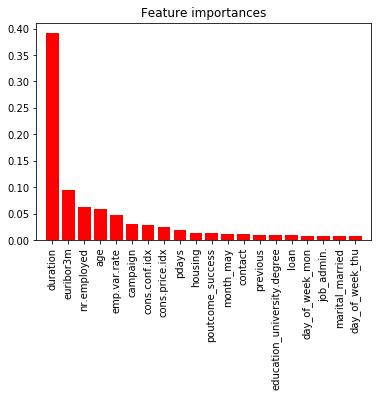

In [13]:
d_first = 20
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align = 'center', color = 'r')
plt.xticks(range(d_first), feature_names[indices[:d_first]], rotation = 90)
plt.xlim([-1, d_first])

In [ ]:
def plot_errors(fig=1, tree_arr, err_test, err_train):
    plt.figure(fig)
    plt.semilogx(tree_arr, err_test, 'b-o', label = 'test')
    plt.semilogx(tree_arr, err_train, 'r-o', label = 'train')
    plt.xlim([np.max(tree_arr), np.min(tree_arr)])
    plt.title('Error vs. Tree count')
    plt.xlabel('tree count')
    plt.ylabel('error')
    plt.legend()

    

In [15]:
trees = np.logspace(0, 3, 40)
err_test = []
err_train = []
oob_scores = []

for tree in trees:
    rf = ensemble.RandomForestClassifier(n_estimators = int(tree), oob_score=True, random_state=50)
    rf.fit(X_train, y_train)

    y_train_predict = rf.predict(X_train)
    y_test_predict = rf.predict(X_test)
    err_train.append(np.mean(y_train.values.ravel() != y_train_predict))
    err_test.append(np.mean(y_test.values.ravel() != y_test_predict))
    oob_scores.append(rf.oob_score_) 
    
plt.figure(1)
plt.semilogx(tree_arr, err_test, 'b-o', label = 'test')
plt.semilogx(tree_arr, err_train, 'r-o', label = 'train')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('Error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('error')
plt.legend()

plt.figure(2)
plt.semilogx(tree_arr, oob_scores, 'b-o', label = 'oob')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('oob error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('oob error')
plt.legend()
pass

c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
c:\python\python36\lib\site-packages\sklearn\ensemble\forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to

KeyboardInterrupt: 

## Extremely Randomized Trees

In [ ]:
ert = ensemble.ExtraTreesClassifier(n_estimators = 100).fit(X_train, y_train)

err_train = np.mean(y_train != ert.predict(X_train))
err_test  = np.mean(y_test  != ert.predict(X_test))

print(err_train, err_test)
print(confusion_matrix(y_test, y_test_predict))

In [ ]:
err_test = []
err_train = []
oob_scores = []

for tree in trees:
    ert = ensemble.ExtraTreesClassifier(n_estimators = int(tree), oob_score=True, random_state=50)
    ert.fit(X_train, y_train)

    y_train_predict = ert.predict(X_train)
    y_test_predict = ert.predict(X_test)
    err_train.append(np.mean(y_train.values.ravel() != y_train_predict))
    err_test.append(np.mean(y_test.values.ravel() != y_test_predict))
    oob_scores.append(ert.oob_score_) 
    
plt.figure(1)
plt.semilogx(tree_arr, err_test, 'b-o', label = 'test')
plt.semilogx(tree_arr, err_train, 'r-o', label = 'train')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('Error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('error')
plt.legend()

plt.figure(2)
plt.semilogx(tree_arr, oob_scores, 'b-o', label = 'oob')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('oob error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('oob error')
plt.legend()
pass

## AdaBoost

In [ ]:
ada = ensemble.AdaBoostClassifier(n_estimators = 1000)
ada.fit(X_train, y_train)

err_train = np.mean(y_train != ada.predict(X_train))
err_test = np.mean(y_test != ada.predict(X_test))

print(err_train, err_test)
print(confusion_matrix(y_test, y_test_predict))

In [ ]:
err_test = []
err_train = []
oob_scores = []

for tree in trees:
    ada = ensemble.AdaBoostClassifier(n_estimators = int(tree), oob_score=True, random_state=50)
    ada.fit(X_train, y_train)

    y_train_predict = ada.predict(X_train)
    y_test_predict = ada.predict(X_test)
    err_train.append(np.mean(y_train.values.ravel() != y_train_predict))
    err_test.append(np.mean(y_test.values.ravel() != y_test_predict))
    oob_scores.append(ada.oob_score_) 
    
plt.figure(1)
plt.semilogx(tree_arr, err_test, 'b-o', label = 'test')
plt.semilogx(tree_arr, err_train, 'r-o', label = 'train')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('Error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('error')
plt.legend()

plt.figure(2)
plt.semilogx(tree_arr, oob_scores, 'b-o', label = 'oob')
plt.xlim([np.max(tree_arr), np.min(tree_arr)])
plt.title('oob error vs. Tree count')
plt.xlabel('tree count')
plt.ylabel('oob error')
plt.legend()
pass

## Gradient Boosted Trees

In [ ]:
gbt = ensemble.GradientBoostingClassifier(n_estimators = 1000)
gbt.fit(X_train, y_train)

err_train = np.mean(y_train != gbt.predict(X_train))
err_test = np.mean(y_test != gbt.predict(X_test))

print(err_train, err_test)
print(confusion_matrix(y_test, y_test_predict))

In [ ]:
err_test = []
err_train = []
oob_scores = []

for tree in trees:
    ada = ensemble.AdaBoostClassifier(n_estimators = int(tree), oob_score=True, random_state=50)
    ada.fit(X_train, y_train)

    y_train_predict = ada.predict(X_train)
    y_test_predict = ada.predict(X_test)
    err_train.append(np.mean(y_train.values.ravel() != y_train_predict))
    err_test.append(np.mean(y_test.values.ravel() != y_test_predict))
    oob_scores.append(ada.oob_score_) 
    
plot_errors(fig=1, tree_arr, err_test, err_train)

plot_errors(fig=2, tree_arr, err_test, err_train)
pass

## Выводы: